In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.models import Sequential
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
import imblearn
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/suicideTextClassification/Data/data.csv')

In [4]:
data.head(10)

,Text,Ideation
0,A life without coffee is a life not worth livi...,0
1,Life without risks is not worth living.,0
2,Living your life in fear is a life not Worth l...,0
3,"Sometimes, I feel like I’m not worth living, I...",1
4,"There is no actual meaning to life, but it doe...",0
5,A life without chocolate is a life not worth l...,0
6,I guess I’m not worth living.,1
7,Life is not worth living without the one you love,0
8,My life is ruined. It's not worth living.,1
9,This lockdown proves a life with no sport is a...,0


In [5]:
data.describe()

,Ideation
count,1285.000000
mean,0.715175
std,0.776281
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,2.000000


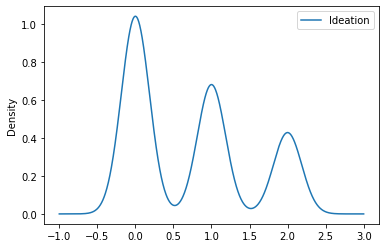

In [6]:
densityPlot = data.plot.kde()

In [7]:
# Data Cleaning

"""
A utility function to remove punctuations from the text.

"""

def remove_punctuations(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text


"""
A utility function to remove numerical characters from the text.

"""

def remove_nums(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text


"""
A utility function to remove URL links from the text.

"""

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


"""
A utility function to remove HTML tags from the text.

"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


"""
A utility function to remove emojis from the text.

"""

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


stop_words = set(stopwords.words('english'))

"""
A utility function to remove stopwords from the text.

"""

def clean_stopwords(text):
    res = [w for w in text.split() if not w in stop_words]
    res_string = " ".join(str(x) for x in res)
    return res_string

In [8]:
data["Text"] = data["Text"].apply(lambda x: remove_punctuations(x))
data["Text"] = data["Text"].apply(lambda x: remove_nums(x))
data["Text"] = data["Text"].apply(lambda x: remove_URL(x))
data["Text"] = data["Text"].apply(lambda x: remove_html(x))
data["Text"] = data["Text"].apply(lambda x: remove_emoji(x))
data["Text"] = data["Text"].apply(lambda x: clean_stopwords(x))

data = data.sample(frac = 1).reset_index(drop=True).reset_index(drop = True)

data.head(10)

,Text,Ideation
0,I got two accidents last year car insurance mo...,0
1,I don’t see problem actually don’t want,0
2,missed Collins birthday want fucking kill,0
3,one deserves feel like suicide answer feeling ...,0
4,please encourage kill genuinely need,1
5,I suicide plan Going enjoy last little moments...,2
6,Dad come pick I’m scared I don’t want anymore,0
7,I don’t want I want die Always sad I’ll never ...,2
8,dont want anymore Just let die,2
9,I don’t get much help hospital I’m suicidal,0


In [9]:
tf.random.set_seed(42)

trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 1200
max_length = 50



# Split Labels

temp = [x for x in data["Text"].tolist()]
train_sentences = temp[:training_size]
test_sentences = temp[training_size:]

temp2 = [x for x in data["Ideation"].tolist()]
train_labels = temp2[:training_size]
test_labels = temp2[training_size:]
tokenizer = Tokenizer(num_words=5000, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

vocab_size = len(tokenizer.word_index) + 1
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [10]:
# Convert to Numpy Array

train_padded = np.array(train_padded)
train_labels = np.array(train_labels)

test_padded = np.array(test_padded)
test_labels = np.array(test_labels)

In [11]:
encoder = OneHotEncoder(sparse = False)
train_labels = train_labels.reshape((len(train_labels), 1))
train_labels = encoder.fit_transform(train_labels)
test_labels = test_labels.reshape((len(test_labels), 1))
test_labels = encoder.fit_transform(test_labels)

In [12]:
train_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [13]:
train_padded

array([[  2, 104, 150, ...,   0,   0,   0],
       [  2,  18,  53, ...,   0,   0,   0],
       [917, 918, 220, ...,   0,   0,   0],
       ...,
       [  2,   5, 197, ...,   0,   0,   0],
       [ 54, 248,  22, ...,   0,   0,   0],
       [179,  67,   9, ...,   0,   0,   0]], dtype=int32)

In [14]:
train_padded.shape

(1200, 50)

In [15]:
train_labels.shape

(1200, 3)

In [16]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    with open(filepath, encoding = 'utf8') as f:
        for line in f:
            values = line.split()
            if values[0] in word_index:
                idx = word_index[values[0]]
                embedding_matrix[idx] = np.asarray(values[1:embedding_dim+1], 'float32')
                
    return embedding_matrix

In [17]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('/content/drive/My Drive/Colab Notebooks/suicideTextClassification/Data/glove.twitter.27B.50d.txt', 
                                           tokenizer.word_index, 
                                           embedding_dim)

In [18]:
model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size, 
                               output_dim = 50,
                               input_length = 50,
                               weights = [embedding_matrix],
                               trainable = True))
model.add(layers.Conv1D(32, 3, padding = 'valid', strides = 1, activation = 'relu'))
model.add(layers.MaxPool1D(pool_size = 3, strides = 1, padding = 'valid'))
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation = 'softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            113400    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 32)            4832      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 46, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 32)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)               

In [19]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [20]:
num_epochs = 30

history = model.fit(train_padded, train_labels, epochs=num_epochs, verbose=1, validation_split=0.05,)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1140 samples, validate on 60 samples
Epoch 1/30
1140/1140 [==============================] - 14s 12ms/step - loss: 1.0212 - accuracy: 0.4596 - val_loss: 1.0076 - val_accuracy: 0.4167
Epoch 2/30
1140/1140 [==============================] - 6s 5ms/step - loss: 0.9395 - accuracy: 0.5482 - val_loss: 0.9130 - val_accuracy: 0.5833
Epoch 3/30
1140/1140 [==============================] - 6s 5ms/step - loss: 0.8848 - accuracy: 0.5772 - val_loss: 0.9203 - val_accuracy: 0.5667
Epoch 4/30
1140/1140 [==============================] - 6s 6ms/step - loss: 0.8160 - accuracy: 0.6316 - val_loss: 0.9008 - val_accuracy: 0.6167
Epoch 5/30
1140/1140 [==============================] - 6s 5ms/step - loss: 0.7852 - accuracy: 0.6351 - val_loss: 0.8697 - val_accuracy: 0.5833
Epoch 6/30
1140/1140 [==============================] - 6s 5ms/step - loss: 0.6990 - accuracy: 0.6877 - val_loss: 0.8980 - val_accuracy: 0.6333
Epoch 7/30
1140/1140 [==============================] - 6s 5ms/step - loss: 0.6625 - acc

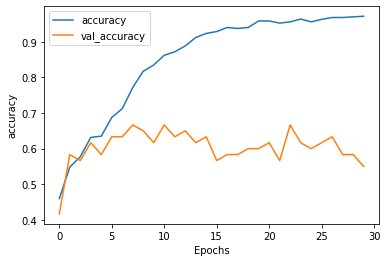

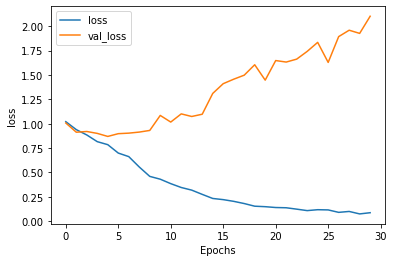

In [21]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [22]:
Y_test_hat = np.array([i.argmax() for i in model.predict(test_padded)])
Y_test = np.array([i.argmax() for i in test_labels])

tp = sum((Y_test == Y_test_hat) & (Y_test == 2))
tn = sum((Y_test == Y_test_hat) & (Y_test != 2))
fp = sum((Y_test != Y_test_hat) & (Y_test_hat == 2))
fn = sum((Y_test != Y_test_hat) & (Y_test == 2))

precision = tp/(tp+fp)
recall = tp/(tp+fn)

f1 = 2 * precision * recall / (precision + recall)
precision, recall, f1

(0.7142857142857143, 0.7894736842105263, 0.7500000000000001)